# Identifying the Content of Images
* Classifying the CIFAR100 dataset images into one of ten categories

## Summary:
**Dataset:** CIFAR100 32x32 pixel coloured images with corresponding content classification number  
**Model:** Convolution Neural Network which classifies the content of an image  
**Particulars:** Architecture based on the AlexNet architecture with appropriate modifications  

## Table of Contents:
* Section 1 - Exploring Data and Pre-processing
* Section 2 - Model and Hyperparameter Tuning
* Section 3 - Final Model and Results

In [3]:
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import datasets
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

from skopt import BayesSearchCV
from skopt.space import Real
from skopt.space import Integer

from scikeras.wrappers import KerasClassifier

In [4]:
print("Python version:", platform.python_version())

Python version: 3.10.12


# Section 1 - Data Exploration

In [5]:
# Importing CIFAR100 data, containing images from 10 different classes with the accompanying class number
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

In [6]:
# Exploring the target variable data

df_y = pd.DataFrame(y_train)

display(df_y.shape)
print("\n")
display(df_y.value_counts())
print("\n")
display(df_y.info())

(50000, 1)

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: count, dtype: int64



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       50000 non-null  uint8
dtypes: uint8(1)
memory usage: 49.0 KB


None

In [7]:
# Exploring the structure of the image data
display(X_train.shape, X_test.shape, X_train.min(), X_train.max())

(50000, 32, 32, 3)

(10000, 32, 32, 3)

0

255

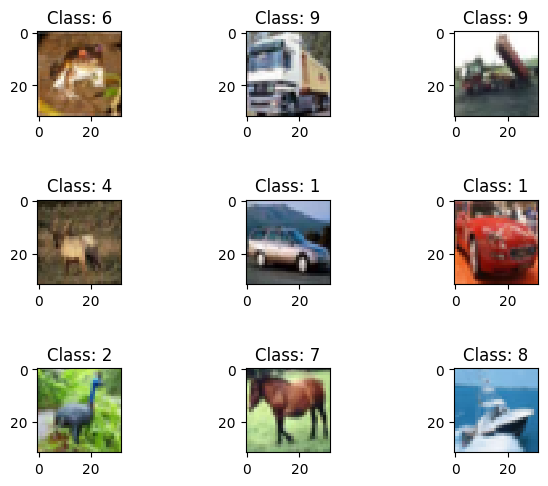

In [8]:
# Displaying several of the 32x32 pixel images from the dataset

fig, axs = plt.subplots(3, 3)

counter = 0
fig.tight_layout()

for ax in axs.ravel():
    ax.imshow(X_train[counter], interpolation="none")
    ax.set_title(f"Class: {y_train[counter][0]}")
    counter += 1

plt.subplots_adjust(hspace=1)

# Section 2 - Model and Hyperparameter Tuning

In [9]:
# Containing neural network architecture within a function for reproducibility and for use in wrapper (see below)


def create_model_function(
    dropout: float, scaling_factor_1: float, scaling_factor_2: float
):
    """
    The fllowing CNN is based on the AlexNet architecture, with deviations outlined below:

    Scaling factors: Used on two layers in order to further reduce model complexity and reduce overfitting.
    -scaling_factor_1 applied on the number of filters of Convolutional Hidden Layers.
    -scaling_factor_2 applied on the flattened Fully Connected Input Layer.
    -AlexNet is designed for 227x227 bit images vs. 32x32 here -> therefore scaling factor applied: 32/227 ≈ 1/7.

      Kernel sizes: All dimensions have been reduced to (2,2).
      -AlexNet kernel size are <= (11,11), therefore they were reduced for this model using the scaling factor of 1/7.

      Strides: All strides have been reduced to (1,1).
      -AlexNet uses strides of <= 4, therefore they were reduced for this model using the scaling factor of 1/7.

    Dropouts: Dropout added after each layer to reduce overfitting due to the higher complexity of AlexNet.
    -AlexNet model is made for 1,000 different classes, compared to only 10 classes here.

    Pooling: Removed the final max pooling layer
    -Image dimensions are small compared to AlexNet and therefore the final compression is removed.

    """

    K.clear_session()
    tf.random.set_seed(0)

    # Convolutional Input Layer
    input = layers.Input(shape=X_train.shape[1:])

    # Convolutional Hidden Layer 1 + MaxPooling 1
    y = layers.Conv2D(
        filters=round(96 * scaling_factor_1),
        kernel_size=(2, 2),
        strides=(1, 1),
        padding="same",
        activation="relu",
    )(input)
    y = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(dropout)(y)

    # Convolutional Hidden Layer 2 + MaxPooling 2
    y = layers.Conv2D(
        filters=round(256 * scaling_factor_1),
        kernel_size=(2, 2),
        strides=(1, 1),
        padding="same",
        activation="relu",
    )(y)
    y = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(dropout)(y)

    # Convolutional Hidden Layers 3, 4, 5
    y = layers.Conv2D(
        filters=round(384 * scaling_factor_1),
        kernel_size=(2, 2),
        strides=(1, 1),
        padding="same",
        activation="relu",
    )(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(dropout)(y)

    y = layers.Conv2D(
        filters=round(384 * scaling_factor_1),
        kernel_size=(2, 2),
        strides=(1, 1),
        padding="same",
        activation="relu",
    )(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(dropout)(y)

    y = layers.Conv2D(
        filters=round(256 * scaling_factor_1),
        kernel_size=(2, 2),
        strides=(1, 1),
        padding="same",
        activation="relu",
    )(y)
    y = layers.BatchNormalization()(y)
    # y = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(y)

    # Fully Connected Input Layer
    y = layers.Flatten()(y)
    # AlexNet flattened layer reduces from 9,216 nodes to 4,096
    nodes_no = round(y.get_shape()[1] * (4096 / 9216) * scaling_factor_2)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(dropout)(y)

    y = layers.Dense(nodes_no, activation="relu")(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(dropout)(y)

    # Fully Connected Hidden Layer 1
    y = layers.Dense(nodes_no, activation="relu")(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(dropout)(y)

    # Fully Connected Hidden Layer 2 (Softmax output)
    # AlexNet has a softmax of 1000, only 10 classes needed here
    output = layers.Dense(10, activation="softmax")(y)

    model = models.Model(input, output)

    model.compile(
        loss=losses.sparse_categorical_crossentropy,
        optimizer=optimizers.Adam(learning_rate=0.001),
        metrics=[metrics.sparse_categorical_accuracy],
    )

    return model

In [10]:
# Using BayesSearchCV to use different hyperparameters with k-fold cross validation

# Initializing variables which will also be used for final model
EPOCHS_NO = 80
BATCH_SIZE_NO = None

# Wrapper needed to use BayesSearchCV on Tensorflow model
wrapper_model = KerasClassifier(
    model=create_model_function,
    dropout=0.5,
    scaling_factor_1=0.5,
    scaling_factor_2=0.5,
)

search_space = {
    "dropout": Real(0.1, 0.9, prior='log-uniform'),
    "scaling_factor_1": Real(0.1, 0.9),
    "scaling_factor_2": Real(0.1, 0.9),
}

BSCV_image_classif = BayesSearchCV(
    wrapper_model,
    search_space,
    n_iter=9,
    cv=3,
    scoring="accuracy",
    random_state=1,
)

BSCV_image_classif.fit(
    X_train, y_train, epochs=EPOCHS_NO, batch_size=BATCH_SIZE_NO, verbose=0
)

# Storing BayesSearchCV results as a dataframe, sorted by score
results_df = pd.DataFrame(BSCV_image_classif.cv_results_)
results_df = results_df.sort_values("mean_test_score", ascending=False).reset_index()

# Storing the best hyperparameter values
best_params = results_df.iloc[0]["params"]

display(results_df[0:3], best_params)

521/521 [==============================] - 20s 37ms/step


,index,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout,param_scaling_factor_1,param_scaling_factor_2,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1,4408.215489,63.350875,9.228444,0.936800,0.449034,0.367685,0.123529,"{'dropout': 0.44903435213027715, 'scaling_fact...",0.761865,0.763545,0.784531,0.76998,0.010312,1
1,8,17648.369745,2064.232298,20.617764,0.691857,0.26727,0.514841,0.792998,"{'dropout': 0.26727045655879356, 'scaling_fact...",0.756885,0.772245,0.749790,0.75964,0.009372,2
2,7,25105.831872,956.316077,32.961492,5.979485,0.200299,0.691104,0.760028,"{'dropout': 0.20029929947782182, 'scaling_fact...",0.763425,0.748125,0.741150,0.75090,0.009303,3


OrderedDict([('dropout', 0.44903435213027715),
             ('scaling_factor_1', 0.36768523616086624),
             ('scaling_factor_2', 0.12352904536025947)])

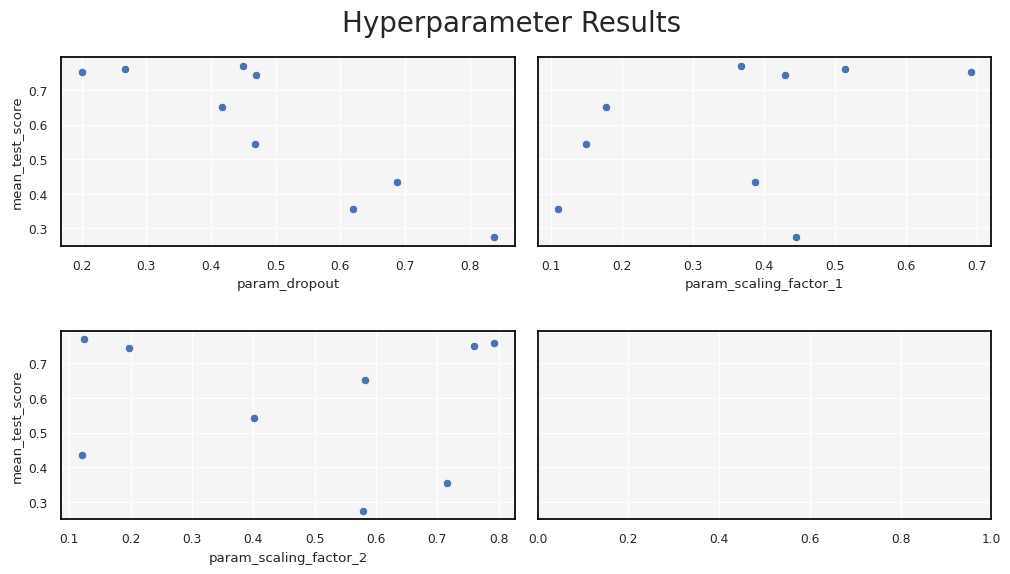

In [11]:
# Plotting the results for different hyperparameters and sets of features

sns.set_theme(
    rc={"axes.facecolor": "whitesmoke", "axes.edgecolor": "black"}, font_scale=0.8
)

fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharey=True)

for i, (param_category, ax) in enumerate(zip(search_space, axs.ravel())):
    sns.scatterplot(
        data=results_df,
        x="param_" + param_category,
        y="mean_test_score",
        ax=ax,
    )

plt.subplots_adjust(wspace=0.05, hspace=0.45)
fig.suptitle("Hyperparameter Results", y=0.96, fontsize=20);

# Section 3 - Final Model and Results

In [12]:
# Generating the final model using the best hyperparameters

final_model = create_model_function(**best_params)

h = final_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS_NO,
    batch_size=BATCH_SIZE_NO,
    validation_data=(X_test, y_test),
    verbose=0,
)

final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 35)        455       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 35)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 16, 16, 35)        140       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 16, 16, 35)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 94)        13254 

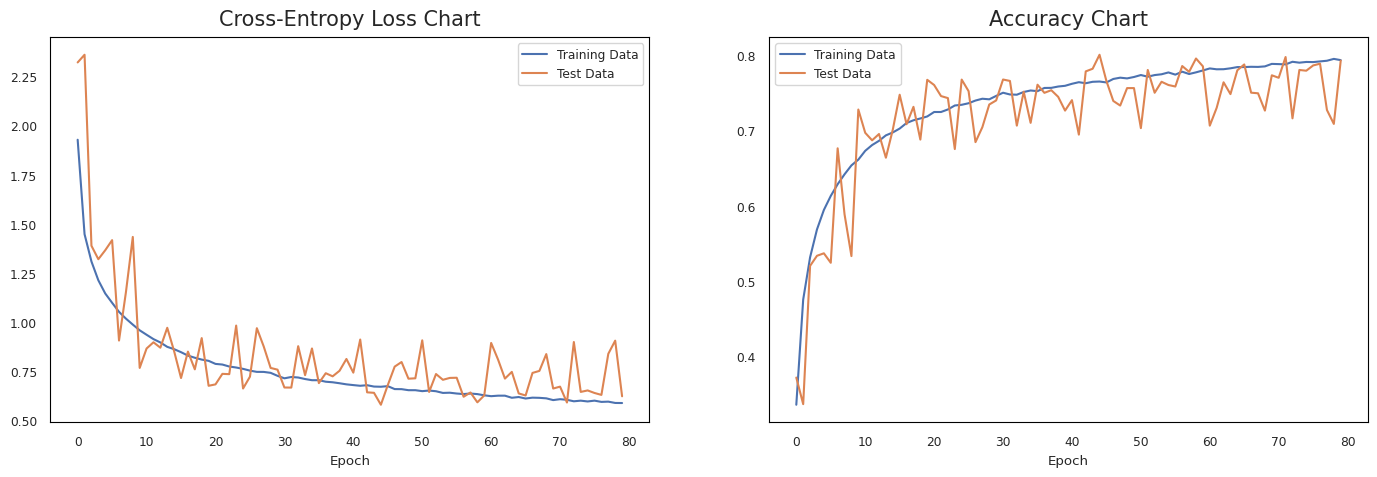

In [13]:
# Plotting the model metrics and scoring for each epoch during training (test set)

sns.set_theme(
    rc={
        "axes.facecolor": "white",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
    },
    font_scale=0.8,
)

fig, ax = plt.subplots(1, 2, figsize=(17, 5))

ax[0].plot(h.history["loss"], label="Training Data")
ax[0].plot(h.history["val_loss"], label="Test Data")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Cross-Entropy Loss Chart", y=1.01, fontsize=15)
ax[0].legend()

ax[1].plot(h.history["sparse_categorical_accuracy"], label="Training Data")
ax[1].plot(h.history["val_sparse_categorical_accuracy"], label="Test Data")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Accuracy Chart", y=1.01, fontsize=15)
ax[1].legend();

In [14]:
# Displaying the final model metrics and scoring on the test set

test_loss, test_accuracy = final_model.evaluate(X_test, y_test)

print(
    f"""
Test Set Cross-Entropy Loss: {test_loss:0.3f}
Test Set Accuracy Score: {test_accuracy:0.3f}
"""
)

313/313 [==============================] - 5s 16ms/step - loss: 0.6233 - sparse_categorical_accuracy: 0.7926

Test Set Cross-Entropy Loss: 0.623
Test Set Accuracy Score: 0.793

